# Interactive collaborative web server


For this example, an empty Seamless project was generated using `seamless-new-project webserver-example`. 

To the empty project notebook, a simple workflow has been added. First, a version that does not use Seamless, in three parts. Then, the Seamless version, with the same three parts.

The workflow is minimalist, but shows a combination of Python and command line tools, as is typical in bioinformatics.

In this example, typically only the final result is shown. In contrast, the `webserver-demo` gives a more step-by-step explanation on how to convert an existing workflow to Seamless.


In [1]:
%run -i load-project.py
await load()

*** define_graph() function is empty. Loading 'graph/webserver-example.seamless' ***

Opened the seamless share update server at port 5138
Opened the seamless REST server at port 5813
Project loaded.

    Main context is "ctx"
    Web/status context is "webctx"

    Open http://localhost:<REST server port> to see the web page
    Open http://localhost:<REST server port>/status/status.html to see the status

    Run save() to save the project workflow file.
    Run export() to generate zip files for web deployment.
    


## Part 1: simple plot in Python

In [2]:
import numpy as np

def gen_wave(period):
    points = np.arange(1000)
    phase = points/period*np.pi*2
    y = np.sin(phase)
    x = np.arange(len(y))
    return x, y

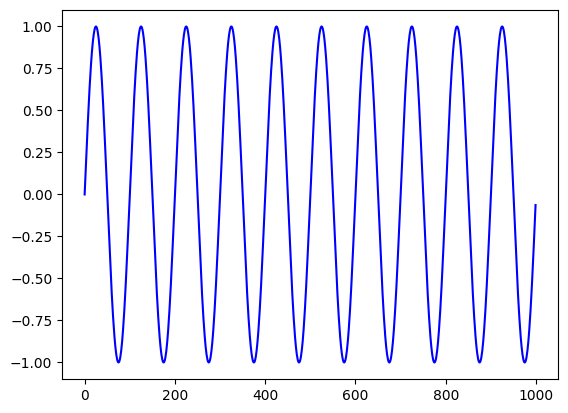

In [3]:
x, y = gen_wave(100)
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(x,y,"b")
plt.show()

## Part 2: Filtering the plot using command line tools

### Generate an initial plot and convert it to text format

In [4]:
x, y = gen_wave(100)
import pandas as pd
df = pd.DataFrame({"x":x,"y":y})
plot = df.to_csv(sep=" ", header=False, index=False)
print(plot[:200])

0 0.0
1 0.06279051952931337
2 0.12533323356430426
3 0.1873813145857246
4 0.2486898871648548
5 0.3090169943749474
6 0.3681245526846779
7 0.4257792915650727
8 0.4817536741017153
9 0.5358267949789967
10 


### Save the text data to disk, filter it using command line tools

In [5]:
with open("plot.txt", "w") as f:
    f.write(plot)
    
# Mirror the signal above 0.8
!awk  -v mirror=0.8 '{y = $2}y > mirror{y=2*mirror - y}{print $1, y}' plot.txt > intermediate.txt

# Eliminate all data points under -0.5 
!awk -v limit=-0.5 '$2 > limit' intermediate.txt > filtered_plot.txt

# Clean up 
!rm -f plot.txt intermediate.txt

# Show the results
!head filtered_plot.txt

0 0.0
1 0.06279051952931337
2 0.12533323356430426
3 0.1873813145857246
4 0.2486898871648548
5 0.3090169943749474
6 0.3681245526846779
7 0.4257792915650727
8 0.4817536741017153
9 0.5358267949789967


### Load the text data back into Python

In [6]:
xy = np.loadtxt("filtered_plot.txt")
x = xy[:, 0]
y = xy[:, 1]

## Part 3: plotting the filtered data

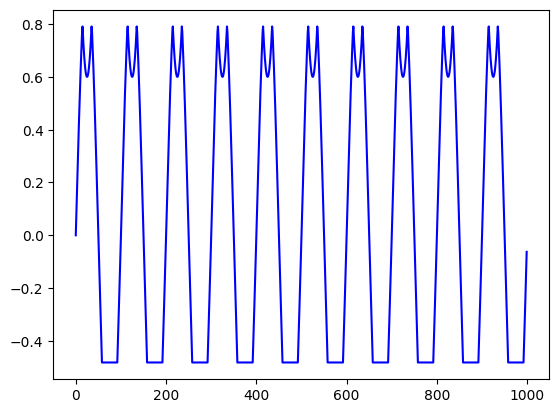

In [7]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(x,y,"b")
plt.show()

## The dependency graph: parameters and code
- Part 1: Procedure to generate the initial plot: 
    - "gen_wave" code 
    - "period" parameter

- Part 2: Filtering the plot: 
  - initial plot input,
  - awk code
  - "mirror" parameter
  - "limit" parameter

- Part 3: Plotting the filtered data: 
  - filtered plot input
  - marker/line parameter
  - figure output
  
Between parts: conversion between Python (Numpy) and text

# Porting it to Seamless

## Parameters

In [8]:
ctx.period = Cell("float").set(100)
ctx.mirror = Cell("float").set(0.8)
ctx.limit = Cell("float").set(-0.5)
ctx.markerline = Cell("str").set("b")

await ctx.translation()

In [9]:
# Jupyter dashboard code, to edit the parameters
from ipywidgets import FloatSlider, Text
from IPython.display import display

def jupyter_dashboard():
    w_period = FloatSlider(description="period",max=1000)
    w_mirror = FloatSlider(description="mirror",min=0,max=1)
    w_limit = FloatSlider(description="limit",min=-1,max=1)
    w_markerline = Text(description="marker/line")
    ctx.period.traitlet().link(w_period)
    ctx.mirror.traitlet().link(w_mirror)
    ctx.limit.traitlet().link(w_limit)
    ctx.markerline.traitlet().link(w_markerline)
    display(w_period)
    display(w_mirror)
    display(w_limit)
    display(w_markerline)

jupyter_dashboard()

FloatSlider(value=100.0, description='period', max=1000.0)

FloatSlider(value=0.8, description='mirror', max=1.0)

FloatSlider(value=-0.5, description='limit', max=1.0, min=-1.0)

Text(value='b', description='marker/line')

## Step 1: Procedure to generate the initial plot

In [10]:
ctx.gen_wave = tf = Transformer()
tf.code = gen_wave  # source code from Python function object
tf.period = ctx.period
ctx.wave = tf.result

await ctx.computation()
ctx.status

Status: {'gen_wave': '*tf*: Status: error', 'wave': 'Status: upstream'}

**The first try gives an error. The cell below displays the reason: we have to import all required modules inside the function**

In [11]:
print(ctx.gen_wave.logs)

Traceback (most recent call last):
  File "Seamless transformer: .gen_wave.tf", line 9, in <module>
    result = gen_wave(period=period)
  File "Seamless transformer: .gen_wave.tf", line 3, in gen_wave
    points = np.arange(1000)
NameError: name 'np' is not defined
*************************************************
Execution time: 0.0 seconds



**Once we do that, it works**

In [12]:
def gen_wave_v2(period):
    import numpy as np
    points = np.arange(1000)
    phase = points/period*np.pi*2
    y = np.sin(phase)
    x = np.arange(len(y))
    return x, y

tf.code = gen_wave_v2
await ctx.computation()
ctx.status

'Status: OK'

## Part 2: Filtering the plot using command line tools

In [13]:
def plot2txt(xy):
    import pandas as pd
    x, y = xy
    df = pd.DataFrame({"x":x,"y":y})
    plot = df.to_csv(sep=" ", header=False, index=False)
    return plot
    
ctx.plot2txt = tf = Transformer()
tf.code = plot2txt
tf.xy = ctx.wave
ctx.plot = tf.result

await ctx.computation()
ctx.status

'Status: OK'

In [14]:
print(tf.logs)

*************************************************
* Result
*************************************************
0 0.0
1 0.06279051952931337
2 0.12533323356430426
3 0.1873813145857246
4 0.2486898871648548
5 0.3090169943749474
6 0.3681245526846779
7 0.4257792915650727
8 0.4817536741017153
9 0.5358267949789967
10 0.5877852522924731
11 0.6374239897486896
12 0.6845471059286886
13 0.7289686274214116
14 0.7705132427757893
15 0.8090169943749475
16 0.8443279255020151
17 0.8763066800438637
18 0.9048270524660196
19 0.9297764858882513
20 0.9510565162951535
21 0.9685831611286311
22 0.9822872507286886
23 0.9921147013144779
24 0.9980267284282716
25 1.0
26 0.9980267284282716
27 0.9921147013144778
28 0.9822872507286886
29 0.9685831611286312
30 0.9510565162951536
31 0.9297764858882513
32 0.9048270524660195
33 0.8763066800438635
34 0.844327925502015
35 0.8090169943749475
36 0.7705132427757893
37 0.7289686274214114
38 0.6845471059286888
39 0.6374239897486899
40 0.5877852522924732
41 0.535826794978997
42 0.48

In [15]:
ctx.filter_plot = tf = Transformer()
tf.language = "bash"
tf.code = """
# Mirror the signal above 0.8
awk  -v mirror=$mirror '{y = $2}y > mirror{y=2*mirror - y}{print $1, y}' plot.txt > intermediate.txt

# Eliminate all data points under -0.5 
awk -v limit=$limit '$2 > limit' intermediate.txt > RESULT
"""
tf["plot.txt"] = ctx.plot
tf.mirror = ctx.mirror
tf.limit = ctx.limit
ctx.filtered_plot = tf.result

await ctx.computation()
ctx.status

'Status: OK'

In [16]:
print(tf.logs)

*************************************************
* Result
*************************************************
0 0.0
1 0.06279051952931337
2 0.12533323356430426
3 0.1873813145857246
4 0.2486898871648548
5 0.3090169943749474
6 0.3681245526846779
7 0.4257792915650727
8 0.4817536741017153
9 0.5358267949789967
10 0.5877852522924731
11 0.6374239897486896
12 0.6845471059286886
13 0.7289686274214116
14 0.7705132427757893
15 0.790983
16 0.755672
17 0.723693
18 0.695173
19 0.670224
20 0.648943
21 0.631417
22 0.617713
23 0.607885
24 0.601973
25 0.6
26 0.601973
27 0.607885
28 0.617713
29 0.631417
30 0.648943
31 0.670224
32 0.695173
33 0.723693
34 0.755672
35 0.790983
36 0.7705132427757893
37 0.7289686274214114
38 0.6845471059286888
39 0.6374239897486899
40 0.5877852522924732
41 0.535826794978997
42 0.4817536741017156
43 0.4257792915650729
44 0.36812455268467814
45 0.3090169943749475
46 0.24868988716485482
47 0.18738131458572502
48 0.12533323356430454
49 0.06279051952931358
50 1.2246467991473532e-16

In [17]:
def txt2plot(plot):
    import numpy as np
    from io import StringIO
    xy = np.loadtxt(StringIO(plot))
    x = xy[:, 0]
    y = xy[:, 1]
    return x, y

ctx.txt2plot = tf = Transformer()
tf.code = txt2plot
tf.plot = ctx.filtered_plot
ctx.filtered_xy = tf.result

await ctx.computation()
ctx.status

'Status: OK'

## Step 3: Plotting

In [18]:
def plot2png(x, y, markerline):
    import matplotlib.pyplot as plt
    import numpy as np
    fig, ax = plt.subplots()
    ax.plot(x, y, markerline)
    from io import BytesIO
    png = BytesIO()
    plt.savefig(png)
    return png.getvalue()

ctx.plot2png = tf = Transformer()
tf.code = plot2png
tf.x = ctx.filtered_xy[0]
tf.y = ctx.filtered_xy[1]
tf.markerline = ctx.markerline
ctx.png = tf.result
ctx.png.celltype = "bytes"

await ctx.computation()
ctx.status

'Status: OK'

**The same Jupyter dashboard, including the plot. Changing the sliders will change the plot interactively**

In [19]:
jupyter_dashboard()

ctx.png.mimetype = "png"
ctx.png.output()

FloatSlider(value=100.0, description='period', max=1000.0)

FloatSlider(value=0.8, description='mirror', max=1.0)

FloatSlider(value=-0.5, description='limit', max=1.0, min=-1.0)

Text(value='b', description='marker/line')

Output(outputs=({'output_type': 'display_data', 'data': {'image/png': 'iVBORw0KGgoAAAANSUhEUgAAAoAAAAHgCAYAAAA…

**Part 1: mount the Python source code and log file to the file system**

**Editing gen_wave.py will update the plot immediately**

In [20]:
ctx.gen_wave.code.mount("gen_wave.py")
ctx.gen_wave.debug.logs_file = "gen_wave.log"
await ctx.computation()

**Part 2: mount the bash source code and log file to the file system**

**Editing filter_plot.bash will update the plot immediately**

In [21]:
ctx.filter_plot.code.mount("filter_plot.bash")
ctx.filter_plot.debug.logs_file = "filter_plot.log"
await ctx.computation()

# Web interface

In [22]:
ctx.period.share(readonly=False)
ctx.mirror.share(readonly=False)
ctx.limit.share(readonly=False)
ctx.markerline.share(readonly=False)
ctx.png.share()
await ctx.computation()

### Seamless projects embed a generator for a web interface. Shared cells are added automatically.

**It also maintains a status web page that visualizes the workflow graph, and its execution status**

**The following link will display the web form (new tab)**

http://localhost:5813/

**The following link will display the status page (new tab)**

http://localhost:5813/status/status.html

**The cell values are in sync with the Jupyter dashboard above.**

**The web interface is also collaborative. When multiple users connect, their updates are synchronized as well.**

**The web interface was customized by manually editing `web/webform.json`.** 

**See `web/webform-AUTOGEN.json` for the original**

In [ ]:
!cp web/webform.json web/webform-CONFLICT.txt